In [1]:
import os
import re
import shutil
from glob import glob
from importlib import reload

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import sign_language_translator as slt

In [ ]:
!slt embed temp_videos/*.mp4 --model-code mediapipe-pose-2-hand-1 \
     --embedding-type all --processes 12 --save-format csv --output-dir temp_landmarks

## trim reference videos

In [2]:
def extract_range(mask: np.ndarray):
    mask[:3] = False
    mask[-3:] = False
    def infer_ranges(mask):
        ranges = []
        true_indices = np.where(mask)[0]
        differences = np.diff(true_indices)

        gap_indices = np.where(differences > 2)[0]

        start = true_indices[0]
        for gap_index in gap_indices:
            end = true_indices[gap_index]
            ranges.append([start, end])
            start = true_indices[gap_index + 1]

        return ranges
    ranges = infer_ranges(mask)
    ranges.extend([[len(mask)-r[1], len(mask)-r[0]] for r in infer_ranges(mask[::-1])])

    start = mask[::-1].argmax()
    end = start+mask[::-1][start:].argmin()
    ranges.append([len(mask)-end, len(mask)-start])

    # filter out outliers
    ranges = sorted([r for r in ranges if 0.15 < (r[1]-r[0])/len(mask) < 0.95], key=lambda r: r[0])

    return ranges

def decompose(n:int, ratio=0.5):
    pairs = []
    for i in range(2, int(n**0.5)+1):
        if n%i==0:
            pairs.append((i, n//i))
    return sorted(pairs, key=lambda x: abs(x[0]/x[1]-ratio))[0]

def get_mask(landmarks: np.ndarray, return_vals={}):
    ls = landmarks[:, 375:][:, 1::5][:, [15,16]]
    # smooth
    lmrks = np.stack([np.convolve(np.pad(ls.T[0], 3, mode="edge"), np.ones(7)/7, mode="valid"),
                    np.convolve(np.pad(ls.T[1], 3, mode="edge"), np.ones(7)/7, mode="valid")]).T

    # left_right_weights = (std:=lmrks.std(axis=0)) / std.sum()
    threshold = (np.percentile(lmrks, 90, axis=0)).min()*0.9 + 0.1* np.percentile(lmrks, 2)
    mask = (lmrks <= threshold).any(axis=1)

    return_vals["ls"] = ls
    return_vals["lmrks"] = lmrks
    return_vals["threshold"] = threshold

    return mask

# extract_range(mask)

In [3]:
# paths = sorted(glob("/Users/mudassar.iqbal/Library/CloudStorage/GoogleDrive-mdsriqb@gmail.com/My Drive/sign-language-translator/sign-language-datasets"+"/sign_recordings/reference_clips/pk-hfad-1/*.mp4"))
done  = [os.path.basename(p) for p in glob("temp_uploaded/*.mp4")]
bases = [os.path.basename(p)[:-4] for p in glob("temp_landmarks/*.mp4.csv")]
paths = ["temp_videos/"+p for p in bases if p not in done]
len(paths)

1

pk-hfad-1_ballpoint.mp4
5.76 25.0 (144, 480, 640, 3) [73, 127] 144 0.375 1.113


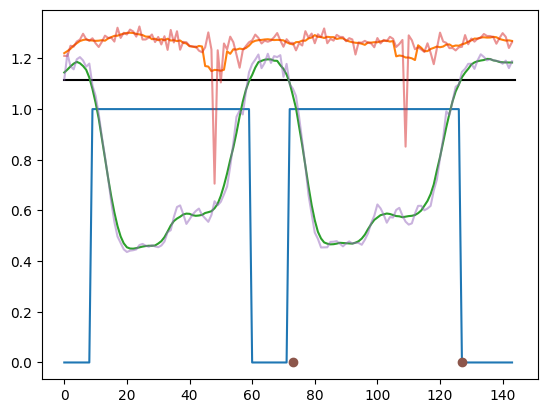

In [4]:
# path = paths[10]
# path = os.path.dirname(paths[0])+"/نہر.mp4"
path = np.random.choice(paths,1)[0]
print(os.path.basename(path))

video = slt.Video(path)#.trim(30,35)
# video.transform(lambda frame: cv2.resize(frame[:, 160:1120], (640, 480)))

# model = slt.models.MediaPipeLandmarksModel()
# landmarks = model.embed(video, landmark_type="image").numpy()
landmarks = np.loadtxt(f"temp_landmarks/{os.path.basename(path)}.csv", delimiter=",")
mask = get_mask(landmarks, return_vals=(stuff:={}))
_ = plt.plot(mask),plt.plot([0,len(mask)],[stuff["threshold"],stuff["threshold"]], color="black"),plt.plot(stuff["lmrks"]),plt.plot(stuff["ls"], alpha=0.5)

range_ = extract_range(mask)[-1]
print(video.duration, video.fps, video.shape, range_, len(mask), (range_[1]-range_[0])/len(mask), round(stuff["threshold"], 4))
_ = plt.plot(range_, [0,0], "o"), plt.show()

pk-hfad-1_ballpoint.mp4 (6, 12) 144 144 [73, 127] [0.375]


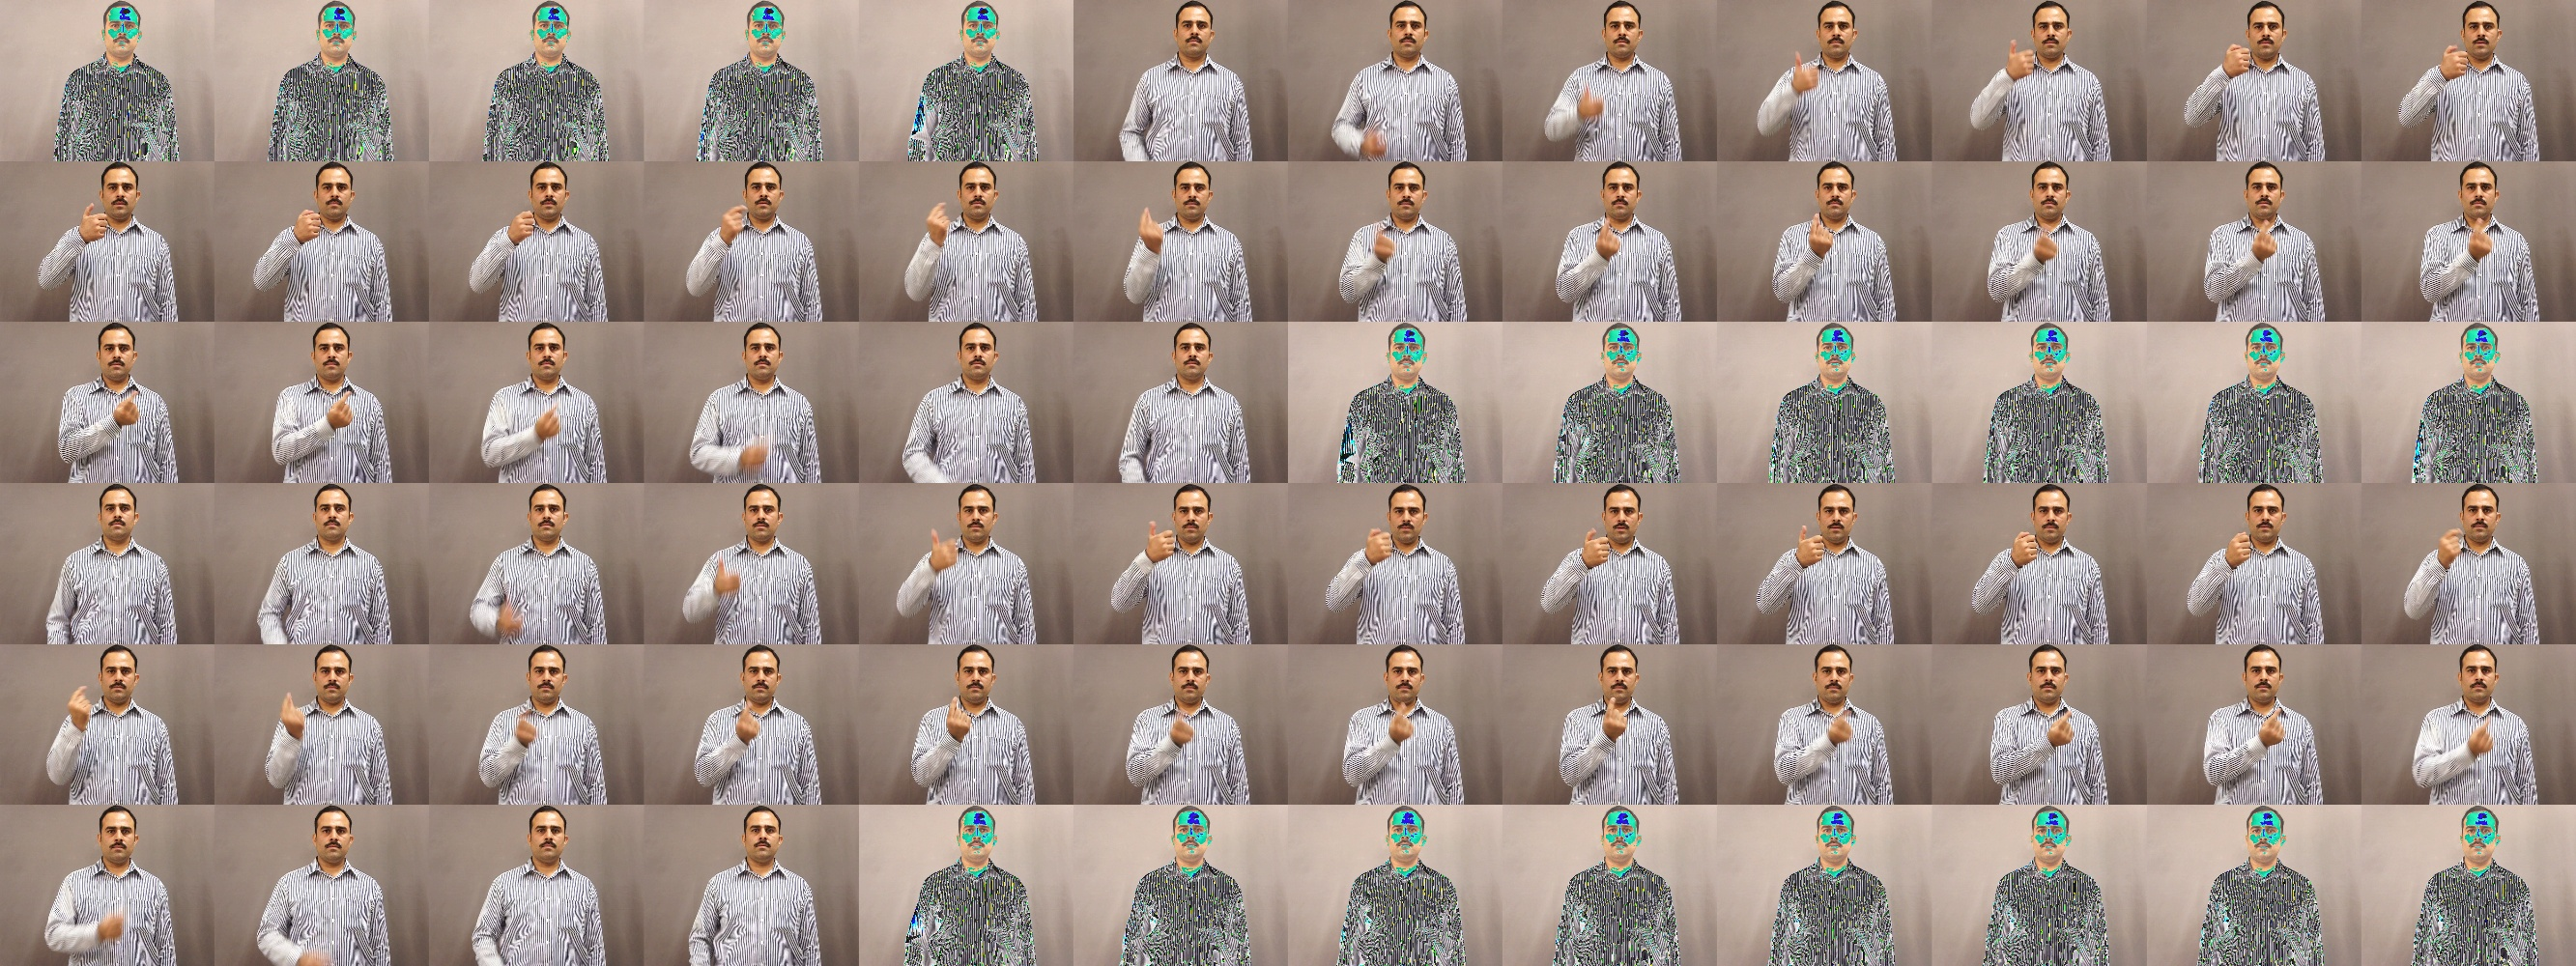

In [5]:
frames = video.numpy()
frames[~mask] += 50

grid = frames[::2].reshape(decompose(len(video)//2)+video.shape[1:]).transpose((0,2,1,3,4))
nrc = grid.shape[0], grid.shape[2]
grid = grid.reshape((-1, )+ grid.shape[2:])
grid = grid.reshape(grid.shape[:1]+(-1, )+ grid.shape[3:])
grid = cv2.resize(grid, (int(grid.shape[1]/grid.shape[0]*1000), 1000))
print(os.path.basename(path), nrc, nrc[0]*nrc[1]*2, len(video), range_, np.diff(range_)/len(video))
slt.Video([grid]).show()

In [ ]:
name = "temp_outputs/" + os.path.basename(path)
print(name)
video[range_[0]-2:range_[1]+2, ].save(name, overwrite=True)
np.savetxt(f"temp_outputs/{os.path.basename(path)}.csv",
               landmarks[range_[0]-2:range_[1]+2], fmt="%0.4f",delimiter=",")
slt.Video(name).show("html5")
# print(4)

## verify outputs

In [ ]:
# length in video metadata == num_frames in landmarks.csv
lens_vl = {
    os.path.basename(p)[:-4]: (slt.Video(p[:-4]).length, len(np.loadtxt(p, delimiter=",")))
    for p in tqdm(sorted(glob("temp_outputs/*.mp4.csv")))
}
lens_v = {k:v[0] for k,v in lens_vl.items()}
lens_l = {k:v[1] for k,v in lens_vl.items()}
len({k:v for k,v in lens_vl.items() if v[0]!=v[1]})

In [ ]:
# histograms of output length and trimming ratio
lens_full = {os.path.basename(p)[:-4]: len(np.loadtxt(p, delimiter=",")) for p in tqdm(sorted(glob("temp_landmarks/*")))}
ratios = {k:lens_l[k]/lens_full[k] for k in lens_l}

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
_=plt.hist(lens_l.values(), bins=30, alpha=1)
plt.subplot(1,2,2)
_=plt.hist(ratios.values(), bins=30, alpha=1)

In [ ]:
# save wrist movements graphs of   outliers in ratios
bounds = np.percentile(list(ratios.values()), [6,94])
for r, n in tqdm(sorted([(round(v,3),k) for k,v in ratios.items()], reverse=True)):
    if bounds[0]<r<bounds[1]:
        continue

    path = f"temp_videos/{n}"
    video = slt.Video(path)

    landmarks = np.loadtxt(f"temp_landmarks/{os.path.basename(path)}.csv", delimiter=",")
    mask = get_mask(landmarks, return_vals=(stuff:={}))
    _ = plt.plot(mask),plt.plot([0,len(mask)],[stuff["threshold"],stuff["threshold"]], color="black"),plt.plot(stuff["lmrks"]),plt.plot(stuff["ls"], alpha=0.5)

    range_ = extract_range(mask)[-1]
    _ = os.makedirs("temp_pics", exist_ok=True), plt.plot(range_, [0,0], "o"), plt.title(f"{r=},{(range_[1]-range_[0])/len(mask):.3f} {stuff['threshold']=:.4f}{n=}"), plt.savefig(f"temp_pics/{r:.3f},{n}.png")
    plt.close()

for p in glob("temp_pics/*"):
    folder = os.path.basename(p).split(",")[0][2]
    os.makedirs(f"temp_pics/{folder}", exist_ok=True)
    os.rename(p, f"temp_pics/{folder}/{os.path.basename(p)}")

## loop

In [20]:
from tqdm.auto import tqdm

# get paths
done = [os.path.basename(p) for p in glob("temp_outputs/*.mp4.csv")]
# done = []
paths = ["temp_videos/"+os.path.basename(p)[:-4] for p in glob("temp_landmarks/*.csv") if os.path.basename(p) not in done]
# paths = sorted(["/Users/mudassar.iqbal/Library/CloudStorage/GoogleDrive-mdsriqb@gmail.com/My Drive/sign-language-translator/sign-language-datasets/sign_recordings/reference_clips/pk-hfad-1/"+p for p in paths if p not in done])

for path in (bar:=tqdm(paths[:])):
    # read file
    base = os.path.basename(path)
    bar.set_description(f"{base:<30}")
    video = slt.Video(path)

    # analyse landmarks
    mask = get_mask(landmarks := np.loadtxt(f"temp_landmarks/{base}.csv", delimiter=","))
    assert len(mask) == len(video)
    _range = extract_range(mask)[-1]

    # trim & save
    video[_range[0]-2:_range[1]+2].save("temp_outputs/"+base, overwrite=True, codec="avc1", progress_bar=False)
    np.savetxt(f"temp_outputs/{os.path.basename(path)}.csv",
               landmarks[_range[0]-2:_range[1]+2], fmt="%0.4f",delimiter=",")

  0%|          | 0/1 [00:00<?, ?it/s]

## github release

#### check uploaded

In [2]:
import subprocess

# !gh release --repo "sign-language-translator/sign-language-datasets" view --json assets | grep "url.*mp4"'''.split()

uploaded = re.findall(r"https.*mp4", subprocess.run([
    "gh", "release", "--repo" , "sign-language-translator/sign-language-datasets", "view", "v0.0.2", "--json", "assets",
], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True).stdout)

len(uploaded)

790

In [4]:
slt.Settings.FILE_TO_URLS.pop("flags.__completely_loaded__", None)
slt.config.settings.get_resource_url("3r897uoihqfvfrbeq9hu")
linked = {k:v for k,v in slt.Settings.FILE_TO_URLS.items() if k.endswith(".mp4")}

len(linked), set(uploaded) - set(linked.values()), set(linked.values()) - set(uploaded)

(790, set(), set())

#### rename to english script

In [8]:
manual_label_to_word = {
    "pk-hfad-1_آ(حرف)": "alif-mad",
    'pk-hfad-1_ت': "tey",
    'pk-hfad-1_چ': "chey",
    'pk-hfad-1_غ': "gaein",
    'pk-hfad-1_ج': "jeem",
    'pk-hfad-1_ہ': "gol-heh",
    'pk-hfad-1_خ': "khhey",
    'pk-hfad-1_ع': "aein",
    'pk-hfad-1_ظ': "zoein",
    'pk-hfad-1_ں': "noon-guna",
    'pk-hfad-1_ھ': "do-chashmi-heh",
    'pk-hfad-1_ص': "suaad",
    'pk-hfad-1_ش': "sheen",
    'pk-hfad-1_ژ': "cey",
    'pk-hfad-1_ض': "zuaad",
    'pk-hfad-1_ط': "toey",
    'pk-hfad-1_ذ': "zaal",
    'pk-hfad-1_ڑ': "rrey",
}
character_map = {
    "آ": "aa",
    "ئ": "e",
    "ؤ": "w",

    'ا': "a",
    'ب': "b",
    'ت': "t",
    'ج': "j",
    'خ': "kh",
    'د': "d",
    'ذ': "z",
    'ر': "r",
    'س': "s",
    'ف': "f",
    'ل': "l",
    'م': "m",
    'و': "o",
    'پ': "p",
    'چ': "ch",
    'ک': "k",
    'گ': "g",
    'ی': "i",
    'ے': "y",

    'ن': "n",
    'ں': "n",
    'ح': "h",
    'ھ': "h",
    'ہ': "h",

}


psl = slt.languages.sign.PakistanSignLanguage()
label_to_words = {}
for label, ls in psl.vocab.word_to_labels.items():
    if not label.isascii():
        continue
    for l in ls:
        if len(l) == 1 and not l[0].isascii():
            if l[0] not in label_to_words:
                label_to_words[l[0]] = []
            label_to_words[l[0]].append(label.replace(" ", "-").replace("(", ".").replace(")", "").replace("'", ""))

label_to_word = {k:v[0] for k,v in label_to_words.items() if len(v)>0}
print(len(label_to_word))
# label_to_word

455


In [10]:
def english_filename(label):
    if (word:=label_to_word.get(label, manual_label_to_word.get(label, None))):
        target = f"{label.split('_')[0]}_{word}.mp4"
    else:
        target = f"{label}.mp4"
        if not target.isascii():
            for k,v in character_map.items():
                target = target.replace(k, v)
        assert target.isascii(), target

    if target.isascii():
        target = target.replace(" ", "-").replace("(", ".").replace(")", ".").replace("'", "").replace("..", ".")

    return target

In [31]:
npt_uploaded_paths = glob("temp_outputs/*.mp4")
path_pairs={}
for src_path in npt_uploaded_paths:
    base = os.path.basename(src_path)
    target = english_filename(base[:-4])
    if not os.path.exists(tgt_path:=f"temp_uploaded/{target}"):
        path_pairs[src_path] = f"temp_uploaded/{target}"
    else:
        print("file exists:", tgt_path)

assert len(path_pairs.values()) == len(set(path_pairs.values())), "repetition in targets"
print(len(path_pairs))
path_pairs

1


{'temp_outputs/pk-hfad-1_ballpoint.mp4': 'temp_uploaded/pk-hfad-1_ballpoint.mp4'}

In [32]:
# move
for src, dst in path_pairs.items():
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if os.path.exists(dst):
        print("File already exists", dst, src)
    shutil.copy2(src, dst)

In [34]:
# {resource_id: url}
{
    f"videos/{os.path.basename(src)}":
    "https://github.com/sign-language-translator/sign-language-datasets/releases/download/v0.0.2/"
    + os.path.basename(dst)
    for src, dst in path_pairs.items()
}

{'videos/pk-hfad-1_ballpoint.mp4': 'https://github.com/sign-language-translator/sign-language-datasets/releases/download/v0.0.2/pk-hfad-1_ballpoint.mp4'}